# Cell Line Analysis

We sought to validate the Ras classifier trained on TCGA pan-cancer data by generating predictions on cell line data. A good classifier should generalize to predicting Ras status in other samples. We apply the classifier on two datasets:

1. [GSE94937](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE94937) from [Kim et al. 2017](http://doi.org/10.1016/j.cels.2017.08.002)
  * Illumina NextSeq 5000 of Human Small Airway Epithelial Cells expressing KRAS G12V and wild-type KRAS
2. [Cancer Cell Line Encyclopedia (CCLE)](https://software.broadinstitute.org/software/cprg/?q=node/11) Gene Expression data.
  * 737 cell lines with matching gene expression and mutation calls
  * Pharmacologic profiling of 24 drugs over 504 cell lines
  
These data were accessed via publicly available resources with help from links in the [UCSD-CCAL Onco-GPS github repository](https://github.com/UCSD-CCAL/onco-gps-paper-analysis)

In [1]:
import os
import numpy as np
import pandas as pd
from decimal import Decimal
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare
from sklearn.preprocessing import StandardScaler
from Bio.SeqUtils import IUPACData

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

/home/gway/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Store protein change dictionary
aa = IUPACData.protein_letters_1to3_extended

In [3]:
%matplotlib inline

## Load Ras Classifier Coefficients

In [4]:
classifier_file = os.path.join('..', 'classifiers', 'RAS', 'classifier_summary.txt')
with open(classifier_file) as class_fh:
    for line in class_fh:
        line = line.strip().split('\t')
        if line[0] == 'Coefficients:':
            all_coef_df = pd.read_table(os.path.join('..', line[1]), index_col=0)

# Only non-zero coefficients contribute to model performance
coef_df = all_coef_df[all_coef_df['abs'] > 0]
print(coef_df.shape)
coef_df.head(10)

(185, 3)


,feature,weight,abs
6702,PBX3,0.139761,0.139761
4592,SPRY2,0.123713,0.123713
6708,C15orf52,0.106100,0.106100
2882,PPP1R3B,0.104700,0.104700
1520,MLPH,0.102069,0.102069
1073,ERRFI1,0.099347,0.099347
4485,CMAS,0.090213,0.090213
3314,MRPS35,0.089351,0.089351
6310,CDK13,-0.083915,0.083915
3589,PDLIM4,-0.082386,0.082386


## Part 1: GSE94937 KRAS Mutant Cell Line Analysis

In [5]:
kras_file = 'https://raw.githubusercontent.com/UCSD-CCAL/onco_gps_paper_analysis/master/data/gene_x_kras_isogenic_and_imortalized_celllines.gct'
kras_cellline_df = pd.read_table(kras_file, skiprows=2, index_col=0)
print(kras_cellline_df.shape)
kras_cellline_df.head()

(38293, 11)


,Description,SLK1_1,SLK2_1,SLK1PU_1,SLK2PU_1,SLKP1_1,SLKP2_1,SLG1_1,SLG2_1,SLGP1_1,SLGP2_1
Name,,,,,,,,,,,
DDX11L1,DDX11L1,0.027446,0.024232,0.053278,0.029142,0.026346,0.062063,0.107488,0.029961,0.000000,0.000000
WASH7P,WASH7P,6.457387,6.500977,9.305351,10.427326,6.852724,7.412390,7.323292,6.745569,7.572732,8.483906
MIR1302-11,MIR1302-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM138A,FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F5,OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# Determine the extent of coefficient overlap
common_genes = list(set(coef_df['feature']) & set(kras_cellline_df.index))
common_coef = coef_df[coef_df['feature'].isin(common_genes)]

print('There are a total of {} out of {} genes in common between the datasets'
      .format(common_coef.shape[0], coef_df.shape[0]))

There are a total of 177 out of 185 genes in common between the datasets


In [7]:
# Subset cell line data and reorder
kras_cellline_df = kras_cellline_df.loc[common_coef['feature'], kras_cellline_df.columns[1:]]
print(kras_cellline_df.shape)

(177, 10)


In [8]:
# Which Genes are Missing?
missing_genes = list(set(coef_df['feature']).difference(set(kras_cellline_df.index)))
all_coef_df[all_coef_df['feature'].isin(missing_genes)]

,feature,weight,abs
6994,KIAA1539,0.069202,0.069202
5954,C12orf11,0.063514,0.063514
7023,ZNF322A,0.048071,0.048071
8033,log10_mut,0.048028,0.048028
4795,C17orf37,-0.034015,0.034015
52,LOC96610,-0.020048,0.020048
7851,LOC25845,-0.008914,0.008914
6614,UPK3BL,-0.006527,0.006527


In [9]:
# Transform the cell line data by z-score
scaled_fit = StandardScaler().fit(kras_cellline_df.T)
kras_cellline_df = pd.DataFrame(scaled_fit.transform(kras_cellline_df.T),
                                index=kras_cellline_df.columns,
                                columns=kras_cellline_df.index)

In [10]:
# Get the weights ready for applying the classifier
apply_weights = pd.DataFrame(common_coef['weight'])
apply_weights.index = common_coef.feature

In [11]:
# Apply a logit transform [y = 1/(1+e^(-wX))] to output probabilities
result = apply_weights.T.dot(kras_cellline_df.T)
result = 1 / (1 + np.exp(-1 * result))

In [12]:
result.T.sort_values(by='weight')

,weight
SLGP2_1,0.193174
SLGP1_1,0.233745
SLG2_1,0.405716
SLG1_1,0.446853
SLK1PU_1,0.477593
SLKP1_1,0.503113
SLKP2_1,0.526634
SLK2PU_1,0.566311
SLK2_1,0.755042
SLK1_1,0.856927


In [13]:
# Mutation status from Onco-GPS repository
output = result.T.assign(Ras_Mutation = [1, 1, 1, 1, 1, 1, -1, -1, -1, -1])
output = output.assign(sample_name = output.index)
output = output.assign(dummy_y = 0)
output

,weight,Ras_Mutation,sample_name,dummy_y
SLK1_1,0.856927,1,SLK1_1,0
SLK2_1,0.755042,1,SLK2_1,0
SLK1PU_1,0.477593,1,SLK1PU_1,0
SLK2PU_1,0.566311,1,SLK2PU_1,0
SLKP1_1,0.503113,1,SLKP1_1,0
SLKP2_1,0.526634,1,SLKP2_1,0
SLG1_1,0.446853,-1,SLG1_1,0
SLG2_1,0.405716,-1,SLG2_1,0
SLGP1_1,0.233745,-1,SLGP1_1,0
SLGP2_1,0.193174,-1,SLGP2_1,0


In [14]:
# Perform a t-test to determine if weights are significantly different
ras_geo_mutant = output[output['Ras_Mutation'] == 1]
ras_geo_wt = output[output['Ras_Mutation'] == -1]

# Output t-test results
t_results_geo_ras = ttest_ind(a = ras_geo_mutant['weight'],
                              b = ras_geo_wt['weight'], equal_var = False)
print('Statistic = {:.2f}, p = {:.2E}'.format(t_results_geo_ras[0],
                                              Decimal(t_results_geo_ras[1])))

Statistic = 3.31, p = 1.16E-2


/home/gway/anaconda3/lib/python3.5/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 6 x 0.5 in image.
  from_inches(height, units), units))
/home/gway/anaconda3/lib/python3.5/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../figures/cell_line/kras_cell_line_predictions.pdf
  warn('Filename: {}'.format(filename))


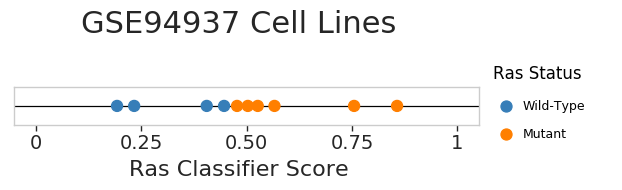

<ggplot: (-9223363264073166862)>

In [15]:
p = (gg.ggplot(output,
               gg.aes(x='weight', y='dummy_y', color='factor(Ras_Mutation)')) +
     gg.geom_hline(gg.aes(yintercept=0), linetype='solid') +
     gg.geom_point(size=4) +
     gg.scale_color_manual(values=["#377eb8", "#ff7f00"], labels=['Wild-Type', 'Mutant']) +
     gg.ylim([-0.1, 0.1]) +
     gg.xlim([-0.001, 1.001]) +
     gg.theme_seaborn(style='whitegrid') +
     gg.xlab('Ras Classifier Score') +
     gg.ylab('') +
     gg.labs(color='Ras Status') +
     gg.ggtitle('GSE94937 Cell Lines\n') +
     gg.theme(
        plot_title=gg.element_text(size=22),
        axis_title_x=gg.element_text(size=16),
        axis_text_x=gg.element_text(size=14),
        axis_text_y=gg.element_blank(),
        axis_ticks_length=4,
        axis_ticks_major_y=gg.element_blank(),
        axis_ticks_minor_y=gg.element_blank(),
        axis_ticks_minor_x=gg.element_blank(),
        legend_position=(1.0, 0.5),
        legend_background=gg.element_blank(),
        legend_key=gg.element_rect(fill='white'),
        legend_text=gg.element_text(size=9),
        legend_title=gg.element_text(size=12),
        panel_border=gg.element_blank(),
        panel_grid_major=gg.element_blank(),
        panel_grid_minor=gg.element_blank()))
kras_fig_file = os.path.join('..', 'figures', 'cell_line', 'kras_cell_line_predictions.pdf')
p.save(kras_fig_file, width=6, height=0.5)
p

## Part 2: CCLE

Note - This data was also retrieved from the Onco-GPS paper analysis repository

In [16]:
ccle_file_name = os.path.join('..', '..', 'onco-gps-paper-analysis', 'data',
                              'rpkm__gene_x_ccle_cellline.gct')
ccle_df = pd.read_table(ccle_file_name, skiprows=2, index_col=0)
print(ccle_df.shape)
ccle_df.head()

(48642, 751)


,Description,A101D_SKIN,A172_CENTRAL_NERVOUS_SYSTEM,A204_SOFT_TISSUE,A2058_SKIN,A2780_OVARY,A375_SKIN,A498_KIDNEY,A549_LUNG,A673_BONE,...,WM88_SKIN,WM983B_SKIN,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Name,,,,,,,,,,,,,,,,,,,,,
DDX11L1,DDX11L1,0.143806,0.000000,0.000000,0.026581,0.000000,0.044352,0.031793,0.153366,0.050799,...,0.000000,0.066865,0.048505,0.000000,0.000000,0.000000,0.07007,0.028786,0.345695,0.049316
WASH7P,WASH7P,10.676400,6.371524,5.081923,10.166624,12.804347,6.835694,5.874934,3.453761,18.524847,...,8.982923,11.572878,6.490550,12.536602,6.839503,9.409850,8.52892,7.445187,20.086628,10.270507
MIR1302-11,MIR1302-11,0.121055,0.000000,0.000000,0.000000,0.129967,0.311123,0.133815,0.000000,0.160357,...,0.000000,0.000000,0.000000,0.780091,0.000000,0.094617,0.00000,0.424061,0.000000,0.000000
FAM138A,FAM138A,0.099803,0.000000,0.000000,0.030746,0.000000,0.006840,0.000000,0.000000,0.000000,...,0.000000,0.041249,0.000000,0.000000,0.000000,0.000000,0.00000,0.119868,0.000000,0.000000
OR4G11P,OR4G11P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.160477,0.000000,0.000000,0.000000,0.000000,0.00000,0.008636,0.000000,0.000000


In [17]:
# Subset to common genes in the classifier and CCLE data
common_genes = list(set(coef_df['feature']) & set(ccle_df.index))
common_ccle_coef = coef_df[coef_df['feature'].isin(common_genes)]
print(common_ccle_coef.shape)
common_ccle_coef.head()

(177, 3)


,feature,weight,abs
6702,PBX3,0.139761,0.139761
4592,SPRY2,0.123713,0.123713
6708,C15orf52,0.106100,0.106100
2882,PPP1R3B,0.104700,0.104700
1520,MLPH,0.102069,0.102069


In [18]:
ccle_df = ccle_df.loc[common_ccle_coef['feature'], ccle_df.columns[1:]]

In [19]:
scaled_fit = StandardScaler().fit(ccle_df.T)
ccle_df = pd.DataFrame(scaled_fit.transform(ccle_df.T),
                            index=ccle_df.columns,
                            columns=ccle_df.index)

In [20]:
# Apply a logit transform [y = 1/(1+e^(-wX))] to output probabilities
result_ccle = apply_weights.T.dot(ccle_df.T)
result_ccle = 1 / (1 + np.exp(-1 * result_ccle))

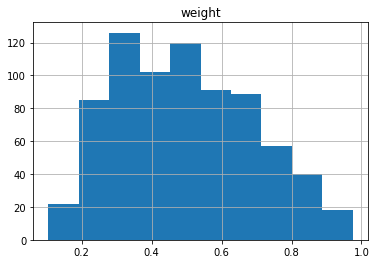

In [21]:
# Distribution of predictions of the Ras Classifier applied to CCLE data
result_ccle.T.hist();

In [22]:
# Load CCLE Mutation Data
ccle_mut_file_name = os.path.join('..', '..', 'onco-gps-paper-analysis', 'data', 
                                  'mutation__gene_x_ccle_cellline.gct')
ccle_all_mut_df = pd.read_table(ccle_mut_file_name, skiprows=2, index_col=0)
ccle_all_mut_df.shape

(63775, 1031)

In [23]:
# Load CCLE Variant Data
ccle_maf_file = 'https://data.broadinstitute.org/ccle/CCLE_DepMap_18Q1_maf_20180207.txt'
ccle_maf_df = pd.read_table(ccle_maf_file, index_col=15)
print(ccle_maf_df.shape)
ccle_maf_df.head(2)

(1175706, 31)


/home/gway/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3,25,26,27,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
22RV1_PROSTATE,AGRN,375790,37,1,979072,979072,+,Silent,SNP,A,...,False,0,NaN,27:24,9:10,9:12,104:20,NaN,NaN,15:13
22RV1_PROSTATE,ATAD3A,55210,37,1,1459233,1459233,+,Silent,SNP,A,...,False,0,0.000008,29:49,33:40,30:38,315:308,NaN,NaN,17:31


In [24]:
# Identify all cell lines with mutations in Ras genes, also subset BRAF mutant samples
ras_genes = ['KRAS_MUT', 'HRAS_MUT', 'NRAS_MUT']
ras_status = ccle_all_mut_df.loc[ras_genes, :].T.apply(max, axis=1)

# BRAF mutations do not contribute to Ras status in this case
ccle_mut_df = (
    ccle_all_mut_df.loc[ras_genes + ['BRAF_MUT'], :].T
    .assign(ras_status=ras_status).drop(['Description'])
    )
print(ccle_mut_df.shape)
ccle_mut_df.head(5)

(1030, 5)


Name,KRAS_MUT,HRAS_MUT,NRAS_MUT,BRAF_MUT,ras_status
DMS53_LUNG,0,0,0,0,0
SW1116_LARGE_INTESTINE,1,0,0,0,1
NCIH1694_LUNG,0,0,0,0,0
P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0,0,0,0,0
HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0,0,1,0,1


In [25]:
# Join classifier scores with mutation status
ccle_full_df = ccle_mut_df.join(result_ccle.T).dropna()
ccle_full_df = ccle_full_df.assign(sample_name = ccle_full_df.index)
ccle_full_df = ccle_full_df.sort_values(by='weight')
print(ccle_full_df.shape)
ccle_full_df.tail(5)

(737, 7)


,KRAS_MUT,HRAS_MUT,NRAS_MUT,BRAF_MUT,ras_status,weight,sample_name
LS1034_LARGE_INTESTINE,1,0,0,0,1,0.941286,LS1034_LARGE_INTESTINE
BEN_LUNG,0,0,0,0,0,0.941964,BEN_LUNG
OCUM1_STOMACH,0,0,0,0,0,0.945538,OCUM1_STOMACH
NCIH650_LUNG,1,0,0,0,1,0.957665,NCIH650_LUNG
TT2609C02_THYROID,0,0,1,0,1,0.975086,TT2609C02_THYROID


In [26]:
# Use Seaborn for the 2nd plot
sns.set(style="whitegrid")
sns.set_context("paper", rc={"font.size":11, "axes.titlesize":11, "axes.labelsize":16,
                             'xtick.labelsize':11, 'ytick.labelsize':11})

### Perform a t-test on classifier weights across groups

In [27]:
# Ras mutant vs. Ras wildtype
ras_mutant = ccle_full_df[ccle_full_df['ras_status'] == 1]
ras_wt = ccle_full_df[ccle_full_df['ras_status'] == 0]

# Also interested in BRAF status within Ras wildtype samples
braf_mutant = ras_wt[ras_wt['BRAF_MUT'] == 1]
braf_wt = ras_wt[ras_wt['BRAF_MUT'] == 0]

# Output t-test results
t_results_ras = ttest_ind(a = ras_mutant['weight'],
                          b = ras_wt['weight'], equal_var = False)
print('Ras Status:')
print(t_results_ras)

t_results_braf = ttest_ind(a = braf_mutant['weight'],
                           b = braf_wt['weight'], equal_var = False)
print('\nBRAF Status in Ras Wild-Type Samples:')
print(t_results_braf)


Ras Status:
Ttest_indResult(statistic=14.212934382489067, pvalue=6.347626627450204e-36)

BRAF Status in Ras Wild-Type Samples:
Ttest_indResult(statistic=7.691780351577681, pvalue=1.1612390405220905e-11)


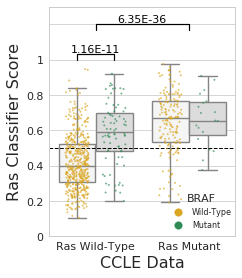

In [28]:
# Plot Results
x1, x2 = 0, 1
x3, x4 = -0.2, 0.2
y1, y2, h = 1.17, 1, 0.03
plt.rcParams['figure.figsize']=(3.5, 4)
ax = sns.boxplot(x="ras_status", y="weight", data=ccle_full_df,
                 hue='BRAF_MUT', palette = {0: "whitesmoke", 1: 'gainsboro'},
                 fliersize=0)
ax = sns.stripplot(x='ras_status', y='weight', hue='BRAF_MUT',
                   data=ccle_full_df, 
                   dodge=True, edgecolor='gray',
                   palette = {1: "seagreen", 0: 'goldenrod'},
                   jitter=0.25, size=2, alpha=0.65)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], ['Wild-Type', 'Mutant'], bbox_to_anchor=(.63, 0.2), loc=2, borderaxespad=0.)
l.set_title("BRAF")
ax.axes.set_ylim(0, 1.3)
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, ''])
ax.set_xticklabels(['Ras Wild-Type', 'Ras Mutant'])
ax.set_ylabel('Ras Classifier Score')
ax.set_xlabel('CCLE Data')
ax.legend
plt.axhline(0.5, color='black', linestyle='dashed', linewidth=1)


# Add Ras T-Test Results
plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1.2, c='black')
plt.text(.5, y1+h, "{:.2E}".format(Decimal(t_results_ras.pvalue)),
         ha='center', va='bottom', color="black")

# Add BRAF t-test results
plt.plot([x3, x3, x4, x4], [y2, y2+h, y2+h, y2], lw=1.2, c='black')
plt.text(0, y2+h, "{:.2E}".format(Decimal(t_results_braf.pvalue)),
         ha='center', va='bottom', color="black")

plt.tight_layout()
ccle_fig_file = os.path.join('..', 'figures', 'cell_line', 'ccle_predictions.pdf')
plt.savefig(ccle_fig_file)

### What percentage of correct classifications in CCLE data?

In [29]:
# Assign a label to what the predictions are given classifier scores
ccle_full_df = ccle_full_df.assign(predictions = 'wild-type')
ccle_full_df.loc[ccle_full_df['weight'] > 0.5, 'predictions'] = 'mutant'

In [30]:
# Stratify cell lines based on predictions and ground truth status
positive_ras_predictions_ccle = ccle_full_df[ccle_full_df['weight'] > 0.5]
negative_ras_predictions_ccle = ccle_full_df[ccle_full_df['weight'] <= 0.5]

positive_ras_lines_ccle = ccle_full_df[ccle_full_df['ras_status'] == 1]
negative_ras_lines_ccle = ccle_full_df[ccle_full_df['ras_status'] == 0]

In [31]:
# Of wild-type Ras cell lines, how many are predicted correctly?
# True Negative Rate, Specificity
negative_ras_lines_ccle['predictions'].value_counts()

wild-type    357
mutant       191
Name: predictions, dtype: int64

In [32]:
# Of mutated Ras cell lines, how many are predicted correctly?
# True Positive Rate (TPR), Recall, Sensitivity
positive_ras_lines_ccle['predictions'].value_counts()

mutant       153
wild-type     36
Name: predictions, dtype: int64

In [33]:
# Of the wild-type predictions, how many are actually wild-type?
# Negative Predictive Value (NPV)
neg_ccle_results = negative_ras_predictions_ccle['ras_status'].value_counts()
true_neg = neg_ccle_results[0]
predicted_condition_neg = neg_ccle_results.sum()

print('{} out of {} Ras wild-type predictions '
      'are true ({:.1f}%)'.format(true_neg, predicted_condition_neg,
                                  true_neg * 100 / predicted_condition_neg))

357 out of 393 Ras wild-type predictions are true (90.8%)


In [34]:
# Of the mutated predictions, how many are actually mutated?
# Positive Predictive Value (PPV) -or- precision
pos_ccle_results = positive_ras_predictions_ccle['ras_status'].value_counts()
false_pos, true_pos = pos_ccle_results
predicted_condition_pos = pos_ccle_results.sum()

print('{} out of {} Ras mutation predictions '
      'are true ({:.1f}%)'.format(true_pos, predicted_condition_pos,
                                  true_pos * 100 / predicted_condition_pos))

153 out of 344 Ras mutation predictions are true (44.5%)


In [35]:
total_correct = true_pos + true_neg
print('{} of {} Total cell lines '
      'predicted correctly ({:.1f}%)'.format(total_correct, ccle_full_df.shape[0],
                                             total_correct * 100 / ccle_full_df.shape[0]))

510 of 737 Total cell lines predicted correctly (69.2%)


In [36]:
# Of the False positives, how many are BRAF mutant?
wt_ras_braf_ccle = positive_ras_predictions_ccle[positive_ras_predictions_ccle['ras_status'] == 0]
braf_neg, braf_pos = wt_ras_braf_ccle['BRAF_MUT'].value_counts()

print('{} of {} total false positives '
      'have BRAF mutations ({:.1f}%)'.format(braf_pos, false_pos,
                                             braf_pos * 100 / false_pos))

56 of 191 total false positives have BRAF mutations (29.3%)


In [37]:
# If include BRAF mutations, how many correct
correct_braf = wt_ras_braf_ccle['BRAF_MUT'].value_counts()[1]
true_pos_with_braf = true_pos + correct_braf
print('Including BRAF mutants, {} of {} Ras mutation predictions '
      'have Ras pathway mutations ({:.1f}%)'.format(true_pos_with_braf,
                                                    predicted_condition_pos,
                                                    true_pos_with_braf * 100 / predicted_condition_pos))

Including BRAF mutants, 209 of 344 Ras mutation predictions have Ras pathway mutations (60.8%)


In [38]:
print('Of the false positives, there are {} BRAF mutated cell lines '
      'and {} BRAF wild-type cell lines'.format(braf_pos, braf_neg))

Of the false positives, there are 56 BRAF mutated cell lines and 135 BRAF wild-type cell lines


In [39]:
total_braf_wildtype, total_braf_mut = ccle_full_df['BRAF_MUT'].value_counts()
print('In all of CCLE, there are {} BRAF mutated cell lines '
      'and {} BRAF wild-type cell lines'.format(total_braf_mut, total_braf_wildtype))

In all of CCLE, there are 97 BRAF mutated cell lines and 640 BRAF wild-type cell lines


## What Ras mutations are identified in False Negatives?

**Variant level predictions in the CCLE**

In [40]:
# How many MAF tumors also have CCLE and mutation data?
len(set(ccle_full_df.index).intersection(set(ccle_maf_df.index)))

708

In [41]:
# Of the false negaves, what RAS mutations do they harbor?
false_negatives_df = negative_ras_predictions_ccle.query('ras_status == 1')
common_neg_ccle_samples = set(ccle_maf_df.index).intersection(set(false_negatives_df.index))
false_neg_maf_df = ccle_maf_df.loc[list(common_neg_ccle_samples), :]

In [42]:
# What about true positives?
true_positives_df = positive_ras_predictions_ccle[positive_ras_predictions_ccle['ras_status'] == 1]
common_pos_ccle_samples = set(ccle_maf_df.index).intersection(set(true_positives_df.index))
true_pos_maf = ccle_maf_df.loc[list(common_pos_ccle_samples), :]

In [43]:
# Subset to only Ras genes
false_neg_ras = false_neg_maf_df.query('Hugo_Symbol in ["KRAS", "HRAS", "NRAS"]')
tru_pos_ras = true_pos_maf.query('Hugo_Symbol in ["KRAS", "HRAS", "NRAS"]')

In [44]:
# Remove duplicate cell-lines. Assume 1 cosmic variant supercedes lack of cosmic
false_neg_dup = false_neg_ras.groupby('Tumor_Sample_Barcode')['isCOSMIChotspot']

cosmic_false_neg = (
    false_neg_dup.value_counts()
    .reset_index(name='count')
    .sort_values(by='isCOSMIChotspot')
    .drop_duplicates(subset='Tumor_Sample_Barcode', keep='last')
)

n_false_neg_cosmic = cosmic_false_neg['isCOSMIChotspot'].value_counts()[1]
n_false_neg_obs = cosmic_false_neg['isCOSMIChotspot'].shape[0]

In [45]:
# What is the proportion of COSMIC variant (True) to non-COSMIC variant (False)
print(cosmic_false_neg['isCOSMIChotspot'].value_counts())
cosmic_false_neg['isCOSMIChotspot'].value_counts(normalize=True)

True     22
False    12
Name: isCOSMIChotspot, dtype: int64


True     0.647059
False    0.352941
Name: isCOSMIChotspot, dtype: float64

In [46]:
# Remove duplicate cell-lines. Assume 1 cosmic variant supercedes lack of cosmic
tru_pos_dup = tru_pos_ras.groupby('Tumor_Sample_Barcode')['isCOSMIChotspot']

cosmic_true_pos = (
    tru_pos_dup.value_counts()
    .reset_index(name='count')
    .sort_values(by='isCOSMIChotspot')
    .drop_duplicates(subset='Tumor_Sample_Barcode', keep='last')
)

n_true_pos_cosmic = cosmic_true_pos['isCOSMIChotspot'].value_counts()[1]
n_tru_pos_obs = cosmic_true_pos['isCOSMIChotspot'].shape[0]

In [47]:
print(cosmic_true_pos['isCOSMIChotspot'].value_counts())
cosmic_true_pos['isCOSMIChotspot'].value_counts(normalize=True)

True     144
False      8
Name: isCOSMIChotspot, dtype: int64


True     0.947368
False    0.052632
Name: isCOSMIChotspot, dtype: float64

In [48]:
# Test if the proportions of observed COSMIC variants are significantly different
# between true positives and false negatives. All of these samples have Ras mutations.
# The question is asking if the proportion of Ras variants annotated in the COSMIC
# database is lower in False negative tumors (those the classifier predicted as
# Ras wild-type) than in True positive tumors
cosmic_prop_chi = proportions_chisquare(count = [n_false_neg_cosmic, n_true_pos_cosmic],
                                        nobs = [n_false_neg_obs, n_tru_pos_obs])

print('Chi Square = {}, p value = {}'.format(cosmic_prop_chi[0], cosmic_prop_chi[1]))
print('There is a significant difference in the expected proportion of COSMIC variants.')

Chi Square = 26.111738595247864, p value = 3.222191172407547e-07
There is a significant difference in the expected proportion of COSMIC variants.


### Add CCLE Variant Scores (nucleotide and amino acid) to Supplementary Data Files

In [49]:
# Load TCGA PanCanAtlas Core Ras Pathway genes
ras_genes_file = os.path.join('..', 'classifiers', 'RAS', 'ras_genes.csv')
ras_core_df = pd.read_table(ras_genes_file)
ras_core_df.head()

,genes,og_tsg
0,ALK,OG
1,ARAF,OG
2,BRAF,OG
3,EGFR,OG
4,ERBB2,OG


In [50]:
# Subset MAF file to Ras pathway variants and merge with CCLE classifier scores
ras_pathway_genes = ras_core_df['genes'].tolist()
all_common_lines = set(ccle_maf_df.index).intersection(set(ccle_full_df.index))

# Subset to common cell lines
subset_maf = ccle_maf_df.loc[list(all_common_lines), :]
subset_maf = (
    subset_maf.query('Hugo_Symbol in @ras_pathway_genes')
    .loc[:, ['Hugo_Symbol', 'Protein_Change', 'cDNA_Change']]
    .merge(ccle_full_df, left_index=True, right_index=True)
)

subset_maf.head(3)

,Hugo_Symbol,Protein_Change,cDNA_Change,KRAS_MUT,HRAS_MUT,NRAS_MUT,BRAF_MUT,ras_status,weight,sample_name,predictions
A101D_SKIN,BRAF,p.V600E,c.1799T>A,0,0,0,1,0,0.447467,A101D_SKIN,wild-type
A101D_SKIN,IGF1R,p.A241T,c.721G>A,0,0,0,1,0,0.447467,A101D_SKIN,wild-type
A172_CENTRAL_NERVOUS_SYSTEM,IGF1R,p.I947I,c.2841C>T,0,0,0,0,0,0.533951,A172_CENTRAL_NERVOUS_SYSTEM,mutant


In [51]:
# Get the mean classifier scores for CCLE nucleotide variants
mean_nuc_data = (
    pd.DataFrame(subset_maf
                 .groupby(['cDNA_Change', 'Hugo_Symbol'])['weight']
                 .mean())
)
mean_nuc_data.columns = ['ccle_mean_weight']
mean_nuc_data = mean_nuc_data.reset_index()

# Get the sd classifier scores for CCLE variants
sd_nuc_data = (
    pd.DataFrame(subset_maf
                 .groupby(['cDNA_Change', 'Hugo_Symbol'])['weight']
                 .std())
)
sd_nuc_data.columns = ['ccle_sd_weight']
sd_nuc_data = sd_nuc_data.reset_index()

# Counts of CCLE variants altering amino acids
count_nuc_data = (
    pd.DataFrame(subset_maf
                 .groupby(['cDNA_Change', 'Hugo_Symbol'])['weight']
                 .count())
)
count_nuc_data.columns = ['ccle_count']
count_nuc_data = count_nuc_data.reset_index()

In [52]:
# Merge protein data
nuc_merge_on = ['Hugo_Symbol', 'cDNA_Change']
nuc_change_df = (
    mean_nuc_data.merge(sd_nuc_data,
                        left_on=nuc_merge_on, right_on=nuc_merge_on)
    .merge(count_nuc_data, left_on=nuc_merge_on, right_on=nuc_merge_on)
)

nuc_change_df.sort_values('ccle_count').tail(5)

,cDNA_Change,Hugo_Symbol,ccle_mean_weight,ccle_sd_weight,ccle_count
601,c.181C>A,NRAS,0.626099,0.134239,15
1505,c.34G>T,KRAS,0.644210,0.146242,21
1536,c.35G>T,KRAS,0.734995,0.121861,33
1532,c.35G>A,KRAS,0.686906,0.142274,44
582,c.1799T>A,BRAF,0.611137,0.146628,59


In [53]:
data_s4_file = os.path.join('..', 'classifiers', 'RAS', 'tables',
                            'nucleotide_mutation_scores.tsv')
data_s4_df = pd.read_table(data_s4_file)

# Merge the CCLE nucleotide scores
data_s4_df = data_s4_df.merge(nuc_change_df, left_on = ['Hugo_Symbol', 'HGVSc'],
                                    right_on = ['Hugo_Symbol', 'cDNA_Change'],
                              how='outer')

updated_data_s4_df = data_s4_df.sort_values(by='count', ascending=False)

updated_data_s4_file = os.path.join('..', 'tables', 'updated_Data_S4.csv')
updated_data_s4_df.to_csv(updated_data_s4_file, sep=',', index=False)
updated_data_s4_df.head()

,HGVSc,Variant_Classification,Hugo_Symbol,Mean,SD,count,low_CI,high_CI,cDNA_Change,ccle_mean_weight,ccle_sd_weight,ccle_count
0,c.1799T>A,Missense_Mutation,BRAF,0.379832,0.222155,453.0,0.358573,0.400416,c.1799T>A,0.611137,0.146628,59.0
1,c.35G>A,Missense_Mutation,KRAS,0.819980,0.126311,166.0,0.800026,0.839292,c.35G>A,0.686906,0.142274,44.0
2,c.35G>T,Missense_Mutation,KRAS,0.825700,0.127124,157.0,0.805609,0.844454,c.35G>T,0.734995,0.121861,33.0
3,c.34G>T,Missense_Mutation,KRAS,0.812311,0.110061,98.0,0.787996,0.833271,c.34G>T,0.644210,0.146242,21.0
4,c.182A>G,Missense_Mutation,NRAS,0.778051,0.146488,91.0,0.743709,0.806067,c.182A>G,0.645535,0.203996,6.0


In [54]:
# Get the mean classifier scores for CCLE variants
mean_protein_data = (
    pd.DataFrame(subset_maf
                 .groupby(['Protein_Change', 'Hugo_Symbol'])['weight']
                 .mean())
)
mean_protein_data.columns = ['ccle_mean_weight']
mean_protein_data = mean_protein_data.reset_index()

# Get the sd classifier scores for CCLE variants
sd_protein_data = (
    pd.DataFrame(subset_maf
                 .groupby(['Protein_Change', 'Hugo_Symbol'])['weight']
                 .std())
)
sd_protein_data.columns = ['ccle_sd_weight']
sd_protein_data = sd_protein_data.reset_index()

# Counts of CCLE variants altering amino acids
count_protein_data = (
    pd.DataFrame(subset_maf
                 .groupby(['Protein_Change', 'Hugo_Symbol'])['weight']
                 .count())
)
count_protein_data.columns = ['ccle_count']
count_protein_data = count_protein_data.reset_index()

In [55]:
# Merge protein data
merge_on = ['Hugo_Symbol', 'Protein_Change']
protein_change_df = (
    mean_protein_data.merge(sd_protein_data,
                            left_on=merge_on, right_on=merge_on)
    .merge(count_protein_data, left_on=merge_on, right_on=merge_on)
)

protein_change_df.sort_values('ccle_count').tail(5)

,Protein_Change,Hugo_Symbol,ccle_mean_weight,ccle_sd_weight,ccle_count
1538,p.Q61K,NRAS,0.626099,0.134239,15
612,p.G12C,KRAS,0.644210,0.146242,21
619,p.G12V,KRAS,0.734995,0.121861,33
614,p.G12D,KRAS,0.686906,0.142274,44
2272,p.V600E,BRAF,0.611137,0.146628,59


In [56]:
# Convert amino acid to 3 letters
protein_convert = [''.join([aa[x] if x in aa.keys() else x for x in y]) 
                   for y in protein_change_df['Protein_Change']]

protein_change_df = protein_change_df.assign(conversion = protein_convert)

In [57]:
data_s5_file = os.path.join('..', 'classifiers', 'RAS', 'tables',
                            'amino_acid_mutation_scores.tsv')
data_s5_df = pd.read_table(data_s5_file)

# Merge the CCLE protein scores
data_s5_df = data_s5_df.merge(protein_change_df, left_on = ['Hugo_Symbol', 'HGVSp'],
                                    right_on = ['Hugo_Symbol', 'conversion'],
                              how='outer')

# Sort by the total number of mutations observed
updated_data_s5_df = (
    data_s5_df.drop(['Protein_Change'], axis=1).sort_values(by='count', ascending=False)
)

updated_data_s5_file = os.path.join('..', 'tables', 'updated_Data_S5.csv')
updated_data_s5_df.to_csv(updated_data_s5_file, sep=',', index=False)
updated_data_s5_df.head()

,HGVSp,Variant_Classification,Hugo_Symbol,Mean,SD,count,low_CI,high_CI,ccle_mean_weight,ccle_sd_weight,ccle_count,conversion
0,p.Val600Glu,Missense_Mutation,BRAF,0.379832,0.222155,453.0,0.360466,0.401139,0.611137,0.146628,59.0,p.Val600Glu
1,p.Gly12Asp,Missense_Mutation,KRAS,0.819980,0.126311,166.0,0.800135,0.838195,0.686906,0.142274,44.0,p.Gly12Asp
2,p.Gly12Val,Missense_Mutation,KRAS,0.825700,0.127124,157.0,0.805637,0.846128,0.734995,0.121861,33.0,p.Gly12Val
3,p.Gly12Cys,Missense_Mutation,KRAS,0.812311,0.110061,98.0,0.789292,0.834025,0.644210,0.146242,21.0,p.Gly12Cys
4,p.Gln61Arg,Missense_Mutation,NRAS,0.778051,0.146488,91.0,0.748909,0.808280,0.645535,0.203996,6.0,p.Gln61Arg


## CCLE - Pharmacologic Efficacy

Here, we process drug efficacy data on the CCLE dataset. Data obtained from https://portals.broadinstitute.org/ccle/data (Pharmacologic profiling) (signin required).

A processed `.tsv` file is output to be visualized in `scripts/viz/ras_ccle_pharmacology.R`.

In [58]:
# Load in pharmacological results
pharm_file = os.path.join('..', 'data', 'CCLE_NP24.2009_Drug_data_2015.02.24.csv')
pharm_df = pd.read_csv(pharm_file, index_col=0)
pharm_df = pharm_df.assign(tissue = [' '.join(x[1:]) for x in pharm_df.index.str.split('_')])

pharm_full_df = pharm_df.merge(ccle_full_df, left_index=True, right_index=True)
pharm_full_df.head()

,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),...,ActArea,tissue,KRAS_MUT,HRAS_MUT,NRAS_MUT,BRAF_MUT,ras_status,weight,sample_name,predictions
A172_CENTRAL_NERVOUS_SYSTEM,A172,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","-.27,.084,-2.7,-6.1,-6.3,-6.1,-15,-22","5.84,1.59,2.77,5.89,2.43,3.25,4.54,7.73",8,Sigmoid,8.419621,8.000000,...,0.36150,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0.533951,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Nilotinib,ABL,".0025,.0080,.025,.080,.25,.80,2.53,8","-.75,3.15,9.45,7.81,1.15,4.57,-3.7,-2.1","6.44,3.36,2.34,1.18,1.86,3.21,4.71,6.22",8,Constant,NaN,8.000000,...,0.00000,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0.533951,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,17-AAG,HSP90,".0025,.0080,.025,.080,.25,.80,2.53,8","-4.1,-3.6,-8.3,-13,-49,-67,-67,-71","2.33,.79,1.76,4.40,3.10,2.19,1.71,2.43",8,Sigmoid,0.179408,0.267499,...,2.46620,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0.533951,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,PHA-665752,c-MET,".0025,.0080,.025,.080,.25,.80,2.53,8","-11,-.73,3.40,1.00,.26,5.42,7.48,10.4",".86,7.72,2.80,14.1,6.64,2.25,7.98,6.82",8,Linear,NaN,8.000000,...,0.08666,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0.533951,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Lapatinib,EGFR,".0025,.0080,.025,.080,.25,.80,2.53,8","3.48,1.18,.20,2.58,-4.6,-2.1,-8.0,-4.2",".91,.27,3.61,4.82,4.66,6.00,3.26,8.81",8,Constant,NaN,8.000000,...,0.00000,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0.533951,A172_CENTRAL_NERVOUS_SYSTEM,mutant


In [59]:
common_celllines_pharm = set(ccle_full_df.index).intersection(set(pharm_df.index))
print('There are {} cell lines in common'.format(len(common_celllines_pharm)))

pharm_full_df['Compound'].value_counts()

There are 388 cell lines in common


Lapatinib       388
AZD0530         388
TAE684          388
PF2341066       388
TKI258          388
PD-0325901      388
Nutlin-3        388
Topotecan       388
Erlotinib       387
LBW242          387
Sorafenib       387
AEW541          387
Paclitaxel      387
17-AAG          387
AZD6244         387
PHA-665752      387
Panobinostat    384
PLX4720         381
ZD-6474         381
L-685458        376
RAF265          349
PD-0332991      324
Nilotinib       311
Irinotecan      237
Name: Compound, dtype: int64

In [60]:
pharm_full_df['tissue'].value_counts()

LUNG                         1991
SKIN                          840
BREAST                        677
PANCREAS                      599
OVARY                         587
CENTRAL NERVOUS SYSTEM        585
LARGE INTESTINE               489
ENDOMETRIUM                   458
STOMACH                       396
LIVER                         388
OESOPHAGUS                    339
URINARY TRACT                 286
SOFT TISSUE                   244
BONE                          236
AUTONOMIC GANGLIA             200
PLEURA                        165
KIDNEY                        163
UPPER AERODIGESTIVE TRACT     156
THYROID                        72
PROSTATE                       48
BILIARY TRACT                  24
Name: tissue, dtype: int64

In [61]:
# What is the cell line tissue representation?
compound_heatmap = pd.pivot_table(pharm_full_df[['tissue', 'Compound']],
                                  columns='tissue', index='Compound',
                                  aggfunc=len)

compound_heatmap = pd.DataFrame(compound_heatmap.unstack()).reset_index()
compound_heatmap.columns = ['tissue', 'Compound', 'count']
compound_heatmap = compound_heatmap.sort_values(by=['tissue', 'Compound'])

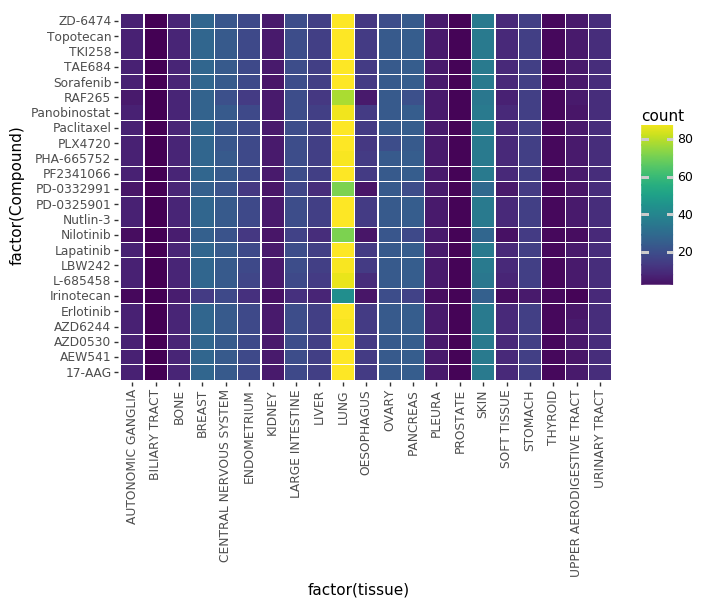

<ggplot: (-9223363264162180327)>

In [62]:
gg.ggplot(compound_heatmap, gg.aes('factor(tissue)', 'factor(Compound)', fill='count')) + \
gg.geom_tile(gg.aes(width=.95, height=.95)) + \
gg.theme(axis_text_x=gg.element_text(rotation=90),
         panel_background=gg.element_rect(fill='white'))

In [63]:
# Write out pharm_full_df to file to plot in ggplot2
# plotnine does not include all the functionality required to create the plot
pharm_file = os.path.join('..', 'data', 'pharmacology_predictions_ccle.tsv')
pharm_full_df.to_csv(pharm_file, sep='\t')